In [1]:
!pip install -q mpl_finance

#Imports

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import pandas as pd
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random

#Data stream clustering

In [3]:
def load_data(ticker, period, interval):
    """
    Load stock data from Yahoo Finance.

    Args:
        ticker (str): Stock ticker symbol.
        period (str): Period to fetch data for (e.g., "1y", "5y").
        interval (str): Data interval (e.g., "1d", "1h", "1m").

    Returns:
        pandas.DataFrame: Stock data with Open, High, Low, Close, and Volume columns.
    """
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval)
    return data

def create_candlestick_pattern(data, window_size):
    """
    Convert stock data into a sequence of candlestick patterns.

    Args:
        data (pandas.DataFrame): Stock data with Open, High, Low, Close, and Volume columns.
        window_size (int): Size of the candlestick pattern window.

    Returns:
        list: List of candlestick patterns, where each pattern is a numpy array.
    """
    patterns = []
    for i in range(len(data) - window_size + 1):
        pattern = np.array(data.iloc[i:i+window_size, :])
        patterns.append(pattern)
    return patterns

def calculate_similarity(pattern1, pattern2, weights=[0.2, 0.2, 0.2, 0.2]):
    """
    Calculate the similarity between two candlestick patterns.

    Args:
        pattern1 (numpy.ndarray): First candlestick pattern.
        pattern2 (numpy.ndarray): Second candlestick pattern.
        weights (list): Weights for different features [close, open, high, low].

    Returns:
        float: Similarity score between the two patterns.
    """
    # Ensure patterns have the same length
    if len(pattern1) != len(pattern2):
        raise ValueError("Patterns must have the same length.")

    # Extract features from patterns
    close1, open1, high1, low1 = pattern1.T[:4]
    close2, open2, high2, low2 = pattern2.T[:4]

    # Calculate feature-wise distances
    close_distance = np.sum(np.abs(close1 - close2))
    open_distance = np.sum(np.abs(open1 - open2))
    high_distance = np.sum(np.abs(high1 - high2))
    low_distance = np.sum(np.abs(low1 - low2))

    # Normalize distances
    close_distance /= len(pattern1)
    open_distance /= len(pattern1)
    high_distance /= len(pattern1)
    low_distance /= len(pattern1)

    # Calculate weighted similarity score
    similarity_score = 1 - (weights[0] * close_distance +
                             weights[1] * open_distance +
                             weights[2] * high_distance +
                             weights[3] * low_distance)

    return similarity_score

def cluster_patterns(patterns, similarity_threshold):
    """
    Cluster candlestick patterns based on similarity.

    Args:
        patterns (list): List of candlestick patterns.
        similarity_threshold (float): Threshold for similarity between patterns.

    Returns:
        list: List of clusters, where each cluster is a list of patterns.
    """
    clusters = []
    for pattern in patterns:
        found_cluster = False
        for cluster in clusters:
            centroid = calculate_centroid(cluster)
            similarity = calculate_similarity(pattern, centroid)
            if similarity >= similarity_threshold:
                cluster.append(pattern)
                found_cluster = True
                break
        if not found_cluster:
            clusters.append([pattern])
    return clusters

def calculate_centroid(cluster):
    """
    Calculate the centroid (representative pattern) of a cluster.

    Args:
        cluster (list): List of candlestick patterns in the cluster.

    Returns:
        numpy.ndarray: Centroid pattern of the cluster (the medoid).
    """
    # Calculate pairwise similarities
    similarities = np.zeros((len(cluster), len(cluster)))
    for i in range(len(cluster)):
        for j in range(i + 1, len(cluster)):
            similarities[i, j] = similarities[j, i] = calculate_similarity(cluster[i], cluster[j])

    # Find the medoid (pattern with minimum sum of dissimilarities)
    medoid_index = np.argmin(np.sum(similarities, axis=1))
    centroid = cluster[medoid_index]

    return centroid

def find_best_representation(cluster):
    """
    Find the best representation (centroid) from all the members in the cluster.

    Args:
        cluster (list): List of candlestick patterns in the cluster.

    Returns:
        numpy.ndarray: Centroid pattern of the cluster (the medoid).
    """
    # Calculate similarities between all pairs of patterns
    similarities = np.zeros((len(cluster), len(cluster)))
    for i in range(len(cluster)):
        for j in range(i + 1, len(cluster)):
            similarities[i, j] = similarities[j, i] = calculate_similarity(cluster[i], cluster[j])

    # Find the pattern with maximum mean similarity
    mean_similarities = np.mean(similarities, axis=1)
    best_representation_index = np.argmax(mean_similarities)
    best_representation = cluster[best_representation_index]

    return best_representation

def plot_clusters(clusters, data):
    """
    Plot the candlestick patterns in multiple clusters using the best representation.

    Args:
        clusters (list): List of clusters, where each cluster is a list of candlestick patterns.
        data (pandas.DataFrame): Original stock data.
    """
    fig, axes = plt.subplots(len(clusters), 1, figsize=(12, 6 * len(clusters)))

    for i, cluster in enumerate(clusters):
        ax = axes[i] if len(clusters) > 1 else axes
        centroid_pattern = find_best_representation(cluster)

        # Extract OHLC data and corresponding dates for the centroid pattern
        window_size = centroid_pattern.shape[0]
        time_index = np.arange(window_size)  # Create a dummy time index
        quotes = np.column_stack((time_index, centroid_pattern[:, :4]))  # Add time index to pattern data
        candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r')
        ax.set_title(f"Cluster {i+1} of {len(cluster)} Patterns")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


def find_k_most_frequent_clusters(clusters, k):
    """
    Find the K most frequent clusters.

    Args:
        clusters (list): List of clusters, where each cluster is a list of candlestick patterns.
        k (int): Number of most frequent clusters to return.

    Returns:
        list: List of the K most frequent clusters.
    """
    cluster_lengths = [(i, len(cluster)) for i, cluster in enumerate(clusters)]
    cluster_lengths.sort(key=lambda x: x[1], reverse=True)

    most_frequent_clusters = [clusters[idx] for idx, _ in cluster_lengths[:k]]
    return most_frequent_clusters


In [4]:
# Load stock data
ticker = "AAPL"
period = "5y"
interval = "1d"
window_size = 10
K = 3
similarity_threshold = 0.8

##Load data

In [5]:
data = load_data(ticker, period, interval)
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-25 00:00:00-04:00,46.091612,46.204730,44.909902,45.424946,175381200,0.0,0.0
2019-03-26 00:00:00-04:00,46.127716,46.421339,44.423738,44.955627,199202000,0.0,0.0
2019-03-27 00:00:00-04:00,45.427355,45.670435,44.897871,45.359966,119393600,0.0,0.0
2019-03-28 00:00:00-04:00,45.475490,45.622301,45.133732,45.420135,83121600,0.0,0.0
2019-03-29 00:00:00-04:00,45.687280,45.747449,45.376808,45.716160,94256000,0.0,0.0


##Clustering

In [6]:
patterns = create_candlestick_pattern(data, window_size)
clusters = cluster_patterns(patterns, similarity_threshold)

##Plot clusters

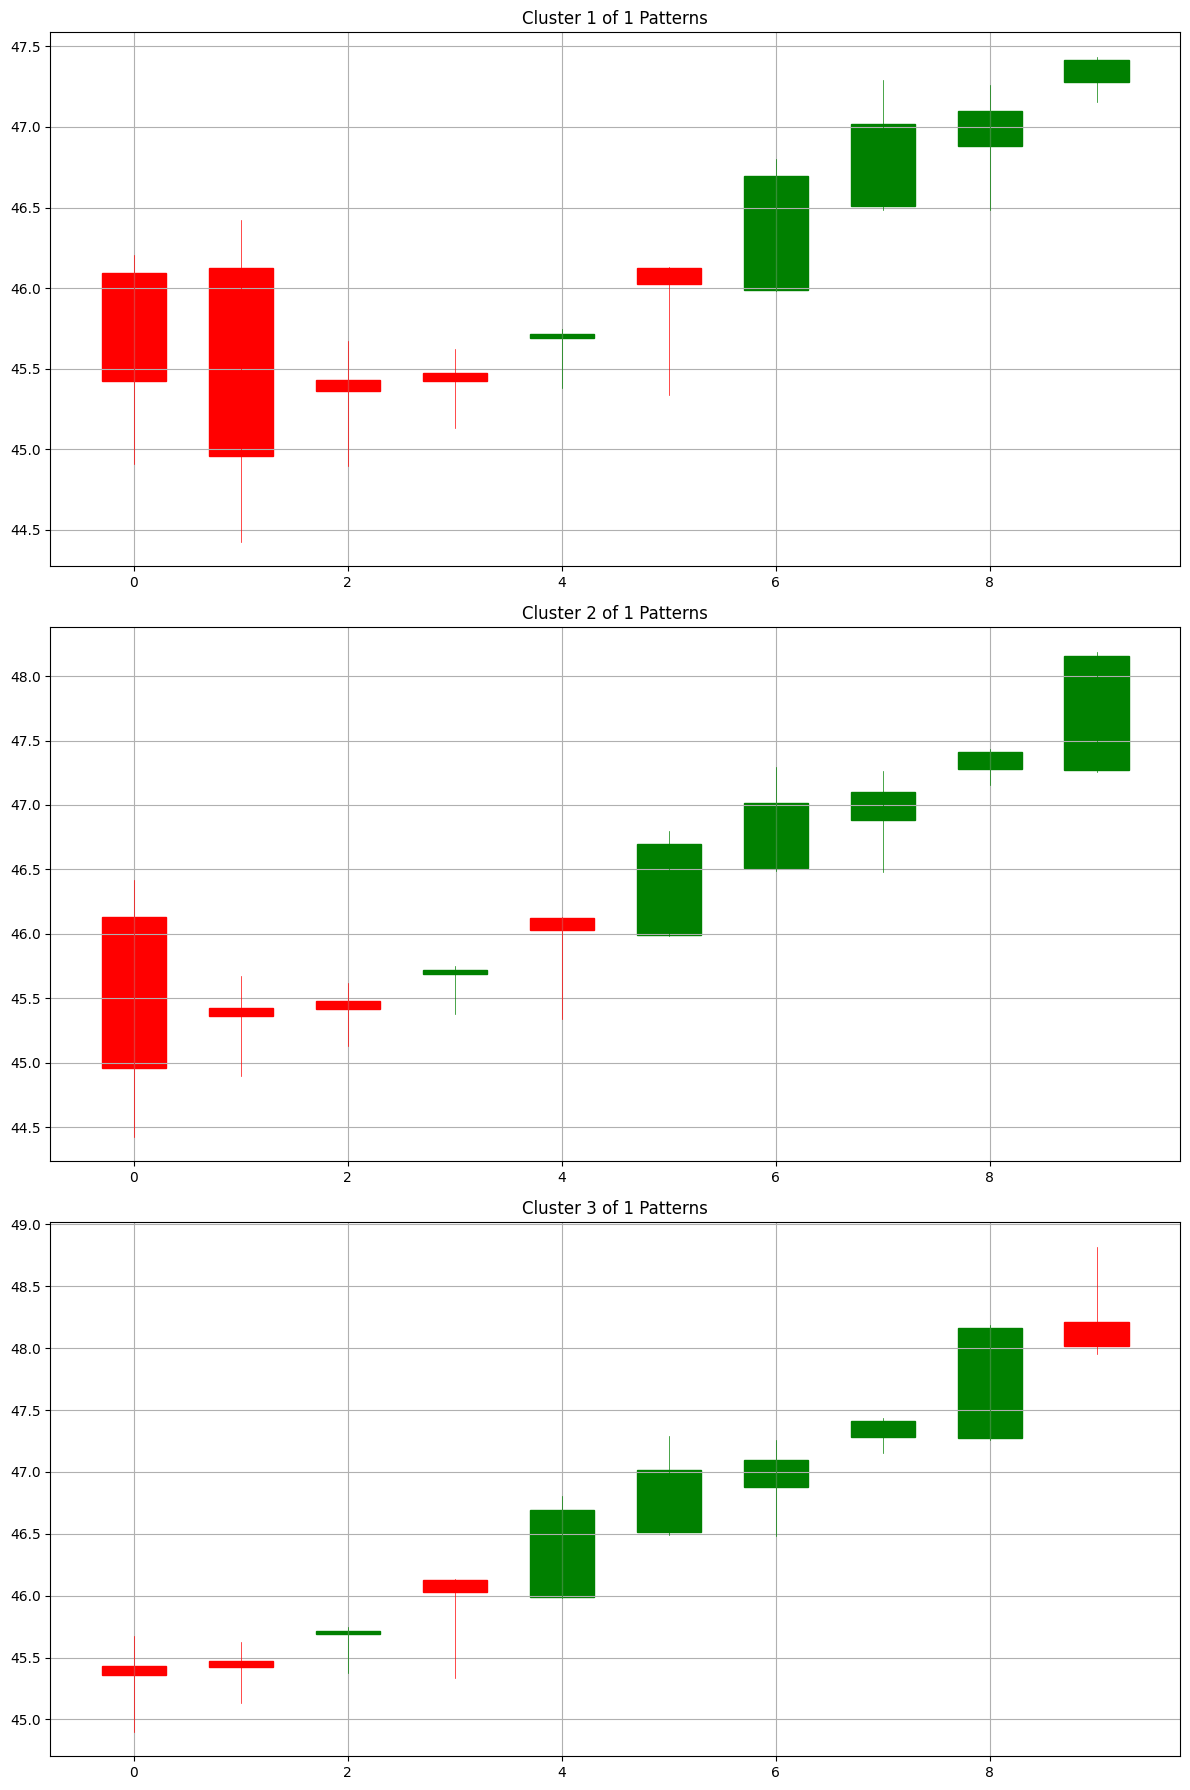

In [7]:
most_frequent_clusters = find_k_most_frequent_clusters(clusters, K)
plot_clusters(most_frequent_clusters, data)

#Kmeans clustering

In [21]:
window_size = 10

In [22]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_patterns(patterns, n_clusters=3):
    """
    Cluster candlestick patterns using k-means clustering.

    Args:
        patterns (list): List of candlestick patterns.
        n_clusters (int): Number of clusters to create.

    Returns:
        list: List of clusters, where each cluster is a list of candlestick patterns.
    """
    # Reshape patterns to 1D arrays for k-means
    reshaped_patterns = [pattern.reshape(-1, ) for pattern in patterns]

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reshaped_patterns)

    # Get cluster assignments
    cluster_labels = kmeans.labels_

    # Group patterns by cluster
    clusters = [[] for _ in range(n_clusters)]
    for pattern, label in zip(patterns, cluster_labels):
        clusters[label].append(pattern)

    return clusters

def plot_cluster_means(clusters, window_size):
    """
    Plot the mean representation of each cluster using candlestick charts.

    Args:
        clusters (list): List of clusters, where each cluster is a list of candlestick patterns.
        window_size (int): Size of the window used for extracting patterns.
    """
    n_clusters = len(clusters)
    n_features = clusters[0][0].shape[1]

    fig, axs = plt.subplots(nrows=n_clusters, ncols=1, figsize=(10, 6 * n_clusters), sharex=True)

    for i, cluster in enumerate(clusters):
        cluster_mean = np.mean(cluster, axis=0)
        cluster_mean = cluster_mean.reshape(window_size, n_features)

        ax = axs[i] if n_clusters > 1 else axs
        ax.set_title(f'Cluster {i + 1} Mean with {len(clusters[i])} members')

        quotes = []
        for j in range(window_size):
            candle = cluster_mean[j]
            quotes.append((j, candle[0], candle[1], candle[2], candle[3]))

        candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r', alpha=0.8)
        ax.set_xlim(-1, window_size)
        ax.set_xticks(range(window_size))
        ax.set_xticklabels([f't-{window_size - j}' for j in range(window_size, 0, -1)])
        ax.set_ylabel('Price')

    plt.tight_layout()
    plt.show()


##Clustering

In [23]:
patterns = create_candlestick_pattern(data, window_size)

clusters = cluster_patterns(patterns, n_clusters=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##Plot clusters

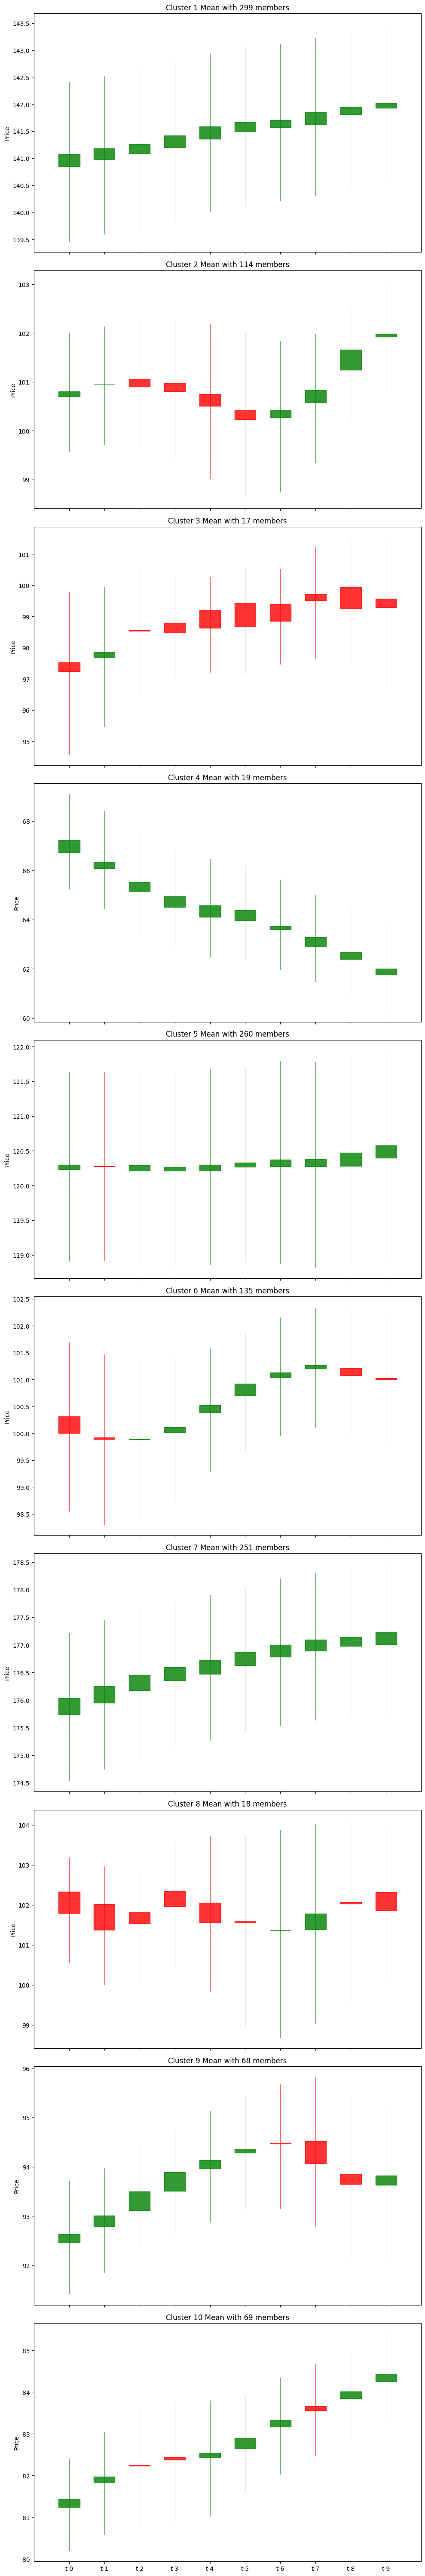

In [24]:
plot_cluster_means(clusters, window_size)

##Feature engineering

In [57]:
feature_num = 6
features = pd.DataFrame()

###Adding features

In [58]:
features['OC ratio'] = data['Open'] / data['Close']

# Calculating LH ratio
features['LH ratio'] = data['Low'] / data['High']

# Calculating Avg trade volume
features['Avg trade volume'] = data['Volume'] / ((data['Low'] + data['High']) / 2)

In [59]:
period = 20
delta = data['Close'].diff()
up, down = delta.clip(lower=0), -1 * delta.clip(upper=0)
ema_up = up.ewm(com=period - 1, adjust=False).mean()
ema_down = down.ewm(com=period - 1, adjust=False).mean()
rs = ema_up / ema_down
rsi = 100 - (100 / (1 + rs))
features['RSI'] = rsi

In [60]:
window = 20
features['SMA'] = data['Close'].rolling(window=window, min_periods=1).mean()
span = 20
features['EMA'] = data['Close'].ewm(span=span, adjust=False, min_periods=1).mean()

###Scaling data

In [61]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns).dropna()
df_concatenated = pd.concat([data.reset_index(drop=True), scaled_features_df], axis=1).dropna()
df_concatenated.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,OC ratio,LH ratio,Avg trade volume,RSI,SMA,EMA
1,46.127716,46.421339,44.423738,44.955627,199202000,0.0,0.0,0.629067,0.616502,0.631859,0.000000,0.005889,0.005501
2,45.427355,45.670435,44.897871,45.359966,119393600,0.0,0.0,0.454309,0.882516,0.372372,0.052641,0.006267,0.005488
3,45.475490,45.622301,45.133732,45.420135,83121600,0.0,0.0,0.452412,0.945740,0.252972,0.060475,0.006556,0.005515
4,45.687280,45.747449,45.376808,45.716160,94256000,0.0,0.0,0.439260,0.972296,0.288130,0.099415,0.007125,0.005729
5,46.122903,46.132528,45.338304,46.026634,111448000,0.0,0.0,0.458616,0.879459,0.342738,0.139460,0.007850,0.006122


In [62]:
def cluster_patterns(patterns, n_clusters=3, feature_num=6):
    """
    Cluster candlestick patterns using k-means clustering.

    Args:
        patterns (list): List of candlestick patterns.
        n_clusters (int): Number of clusters to create.

    Returns:
        list: List of clusters, where each cluster is a list of candlestick patterns.
    """
    # Reshape patterns to 1D arrays for k-means
    reshaped_patterns = [pattern[:, -feature_num:].reshape(-1, ) for pattern in patterns]

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reshaped_patterns)

    # Get cluster assignments
    cluster_labels = kmeans.labels_

    # Group patterns by cluster
    clusters = [[] for _ in range(n_clusters)]
    for pattern, label in zip(patterns, cluster_labels):
        clusters[label].append(pattern)

    return clusters


def plot_cluster_means(clusters, window_size, feature_num):
    """
    Plot the mean representation of each cluster using candlestick charts.

    Args:
        clusters (list): List of clusters, where each cluster is a list of candlestick patterns.
        window_size (int): Size of the window used for extracting patterns.
    """
    n_clusters = len(clusters)

    fig, axs = plt.subplots(nrows=n_clusters, ncols=1, figsize=(10, 6 * n_clusters), sharex=True)

    for i, cluster in enumerate(clusters):
        cluster_mean = np.mean(cluster, axis=0)
        cluster_mean = cluster_mean.reshape(window_size, feature_num+7)

        ax = axs[i] if n_clusters > 1 else axs
        ax.set_title(f'Cluster {i + 1} Mean with {len(clusters[i])} members')

        quotes = []
        for j in range(window_size):
            candle = cluster_mean[j]
            quotes.append((j, candle[0], candle[1], candle[2], candle[3]))

        candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r', alpha=0.8)
        ax.set_xlim(-1, window_size)
        ax.set_xticks(range(window_size))
        ax.set_xticklabels([f't-{window_size - j}' for j in range(window_size, 0, -1)])
        ax.set_ylabel('Price')

    plt.tight_layout()
    plt.show()



def plot_cluster_sample(clusters, window_size, feature_num, cluster_index=0, k=3):
    """
    Plot k random samples and the mean representation from the specified cluster using candlestick charts.

    Args:
        clusters (list): List of clusters, where each cluster is a list of candlestick patterns.
        window_size (int): Size of the window used for extracting patterns.
        feature_num (int): Number of additional features in the data.
        cluster_index (int): Index of the cluster to plot samples from.
        k (int): Number of random samples to plot.
    """
    cluster = clusters[cluster_index]
    random_samples = random.sample(cluster, k)
    cluster_mean = np.mean(cluster, axis=0)

    fig, axs = plt.subplots(nrows=k+1, ncols=1, figsize=(10, 6 * (k+1)), sharex=True)

    for i, sample in enumerate(random_samples):
        sample = sample.reshape(window_size, feature_num+7)
        ax = axs[i]
        ax.set_title(f'Random Sample {i+1} from Cluster {cluster_index + 1}')

        quotes = []
        for j in range(window_size):
            candle = sample[j]
            quotes.append((j, candle[0], candle[1], candle[2], candle[3]))

        candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r', alpha=0.8)
        ax.set_xlim(-1, window_size)
        ax.set_xticks(range(window_size))
        ax.set_xticklabels([f't-{window_size - j}' for j in range(window_size, 0, -1)])
        ax.set_ylabel('Price')

    cluster_mean = cluster_mean.reshape(window_size, feature_num+7)
    ax = axs[-1]
    ax.set_title(f'Cluster {cluster_index + 1} Mean with {len(cluster)} members')

    quotes = []
    for j in range(window_size):
        candle = cluster_mean[j]
        quotes.append((j, candle[0], candle[1], candle[2], candle[3]))

    candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r', alpha=0.8)
    ax.set_xlim(-1, window_size)
    ax.set_xticks(range(window_size))
    ax.set_xticklabels([f't-{window_size - j}' for j in range(window_size, 0, -1)])
    ax.set_ylabel('Price')

    plt.tight_layout()
    plt.show()

###Clustering and plotting it

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


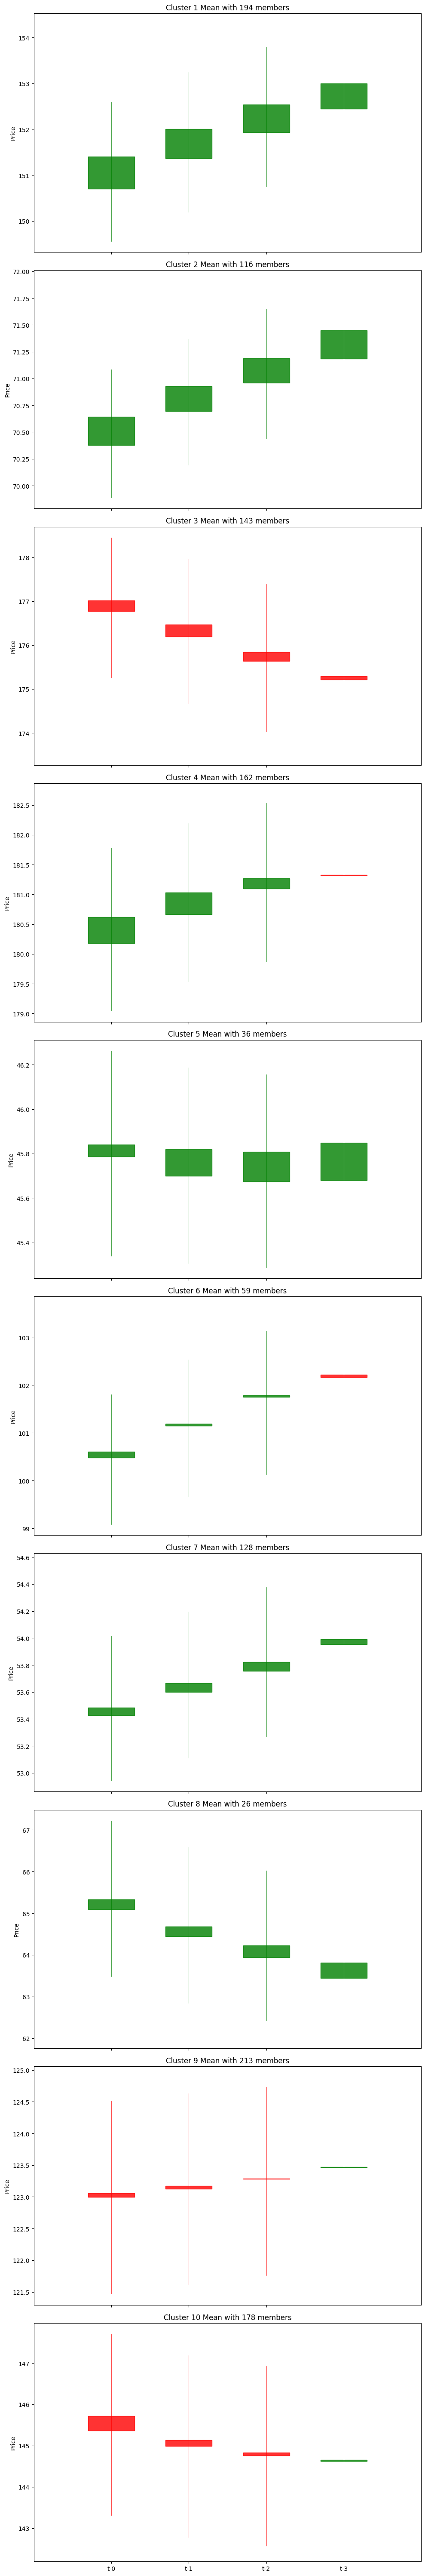

In [63]:
patterns = create_candlestick_pattern(df_concatenated, window_size-1)
clusters = cluster_patterns(patterns, n_clusters=10, feature_num=feature_num)
plot_cluster_means(clusters, window_size-1, feature_num=feature_num)

#Prediction

In [64]:
predict_interval = 1
prediction_steps = 2

In [85]:
def predict_next_candle(current_sequence, similar_pattern):
    """
    Predict the next candlestick based on the most similar pattern.

    Args:
        current_sequence (numpy.ndarray): Current sequence of candlestick patterns.
        similar_pattern (numpy.ndarray): Most similar pattern.

    Returns:
        numpy.ndarray: Predicted next candlestick pattern.
    """
    # Calculate the difference between the last two candles in the similar pattern
    last_candle = similar_pattern[-1]
    second_last_candle = similar_pattern[-2]
    diff = last_candle - second_last_candle

    # Calculate the weighted average using the last candle and the difference
    weight = 5 # Adjust this value to control the influence of the similar pattern
    predicted_candle = current_sequence[-1] + weight * diff

    return predicted_candle



def calculate_similarity(pattern1, pattern2, weights=[0.2, 0.2, 0.2, 0.2]):
    """
    Calculate the similarity between two candlestick patterns.

    Args:
        pattern1 (numpy.ndarray): First candlestick pattern.
        pattern2 (numpy.ndarray): Second candlestick pattern.
        weights (list): Weights for different features [close, open, high, low].

    Returns:
        float: Similarity score between the two patterns.
    """
    # Ensure patterns have the same length
    if len(pattern1) != len(pattern2):
        raise ValueError("Patterns must have the same length.")

    # Extract features from patterns
    close1, open1, high1, low1, Volume, Dividends, Stock_splits, _, _, _, _, _, _ = pattern1.T
    close2, open2, high2, low2, Volume, Dividends, Stock_splits, _, _, _, _, _, _ = pattern2.T

    # Calculate feature-wise distances
    close_distance = np.sum(np.abs(close1 - close2))
    open_distance = np.sum(np.abs(open1 - open2))
    high_distance = np.sum(np.abs(high1 - high2))
    low_distance = np.sum(np.abs(low1 - low2))

    # Normalize distances
    close_distance /= len(pattern1)
    open_distance /= len(pattern1)
    high_distance /= len(pattern1)
    low_distance /= len(pattern1)

    # Calculate weighted similarity score
    similarity_score = 1 - (weights[0] * close_distance +
                             weights[1] * open_distance +
                             weights[2] * high_distance +
                             weights[3] * low_distance)

    return similarity_score

def find_best_cluster_and_centroid(sequence, clusters):
    """
    Find the best cluster for a given sequence and its centroid pattern.

    Args:
        sequence (numpy.ndarray): Input sequence of candlestick patterns.
        clusters (list): List of clusters, where each cluster is a list of candlestick patterns.

    Returns:
        tuple: Tuple containing the best cluster and its centroid pattern.
    """
    best_cluster = None
    best_centroid = None
    min_distance = float('inf')

    for cluster in clusters:
        centroid = np.mean(cluster, axis=0)
        distance = calculate_similarity(sequence, centroid)

        if distance < min_distance:
            min_distance = distance
            best_cluster = cluster
            best_centroid = centroid

    return best_cluster, best_centroid

def split_data(data, train_ratio=0.8):
    """
    Split the data into training and test sets.

    Args:
        data (pandas.DataFrame): Original stock data.
        train_ratio (float): Ratio of data to use for training.

    Returns:
        tuple: Tuple containing train and test data.
    """
    split_index = int(len(data) * train_ratio)
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data

def extract_sequences(data, window_size):
    """
    Extract sequences of candlestick patterns from the data.

    Args:
        data (pandas.DataFrame): Original stock data.
        window_size (int): Size of the window.

    Returns:
        list: List of sequences, where each sequence is a list of candlestick patterns.
    """
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequence = np.array(data.iloc[i:i+window_size, :])
        sequences.append(sequence)
    return sequences

def plot_predicted_candles(predicted_candles, real_candles):
    """
    Plot the predicted candles alongside the real candles.

    Args:
        predicted_candles (numpy.ndarray): Predicted candlestick patterns.
        real_candles (numpy.ndarray): Real candlestick patterns.
    """
    # Plot the candles
    plt.figure(figsize=(12, 6))
    time_index = np.arange(len(real_candles))
    real_candles_with_time = np.column_stack((time_index, real_candles[:, 1]))
    predicted_candles_with_time = np.column_stack((time_index, predicted_candles[:, 1]))
    plt.plot(real_candles_with_time[:, 0], real_candles_with_time[:, 1], label='Real Close', color='blue')
    plt.plot(predicted_candles_with_time[:, 0], predicted_candles_with_time[:, 1], label='Predicted Close', color='red')
    plt.title('Predicted vs Real Close Prices')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()


##Clustering using Kmeans and new features

In [86]:
patterns = create_candlestick_pattern(df_concatenated, window_size - 1)
clusters = cluster_patterns(patterns, n_clusters=50)

train_data, test_data = split_data(df_concatenated, 0.75)
train_sequences = extract_sequences(train_data, window_size - 1)
test_sequences = extract_sequences(test_data, window_size)

# Initialize list to store candles with the last window_size - 1 candles separately
real_candles = np.array([sequence[-predict_interval] for sequence in test_sequences])
real_full_candles = [sequence for sequence in test_sequences]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##Predicting with steps

In [87]:
predicted_candles = []
# Predict candles using previous predictions
for step in range(0, 50, prediction_steps):
    # Use the real data of the last prediction interval to predict the next interval
    input_sequence = real_full_candles[step:step + window_size - 1]

    # Predict candles for the current interval
    for _ in range(prediction_steps):
        try: # for the last interval
            best_cluster, similar_pattern = find_best_cluster_and_centroid(np.array(input_sequence), clusters)
        except ValueError:
            pass

        predicted_candle = predict_next_candle(input_sequence, similar_pattern)

        predicted_candles.append(predicted_candle)

        input_sequence = input_sequence[1:] + [predicted_candle]

predicted_candles = np.array(predicted_candles)

real_candles = real_candles[:len(predicted_candles)]

##Plot predictions

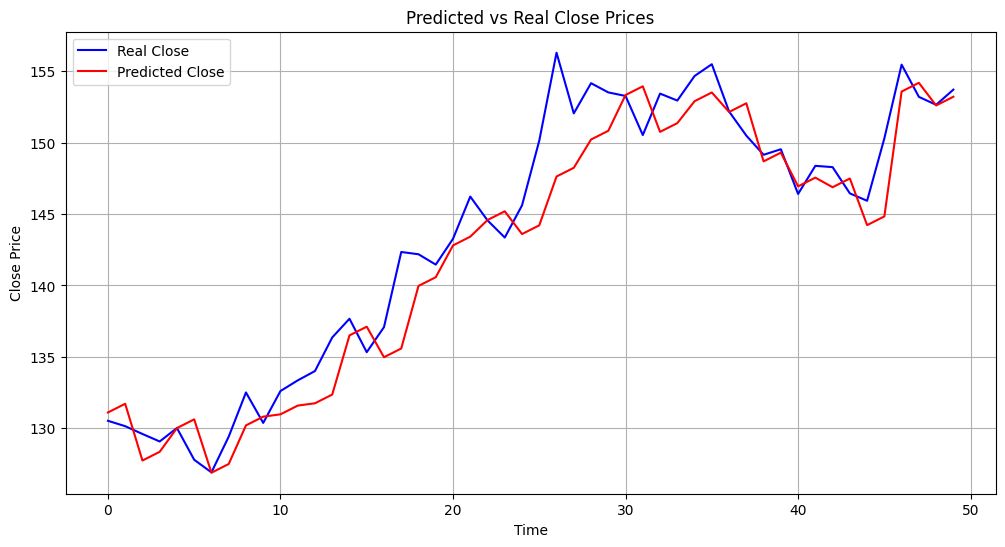

In [88]:
plot_predicted_candles(predicted_candles, real_candles)